# **Классификация наличия святого Георгия на изображении.**

## **Задание.**

Создать модель по классификации изображений, которая будет определять наличие святого Георгия на нем. В нашем распоряжении есть два csv файла со ссылками на изображения со святым Георгием (georges.csv) и без него (non_georges.csv).

## 1. Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing import image as image_prep
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import albumentations as A

IMG_SIZE = 256
SEED = 404
BATCH_SIZE = 32

## 2. Импорт файлов и предобработка.

Изображения вместе с csv-файлами были загружены на диск Google Drive в архиве images. Подключаем Google Drive, скачиваем изображения и распаковываем их для дальнейшего использования.

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
zip_file = '/content/gdrive/MyDrive/images.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

path = '/content/images'

print(os.listdir())

Mounted at /content/gdrive
['.config', 'images', 'gdrive', 'non_georges.csv', 'georges.csv', 'sample_data']


При обучении моделей будем использовать метод `flow_from_dataframe`, поэтому подготовим датафрейм с именами изображений и соотвествующими метками:

1. Читаем каждый csv-файл.
2. Добавляем метки 1 или 0 в зависимости от файла.
3. Удаляем дубликаты изображений.

In [3]:
georges = pd.read_csv('/content/georges.csv', names=['image_id'])
georges['image_id'] = georges['image_id'].apply(lambda x: os.path.basename(x))
georges = georges.drop_duplicates()
georges['label'] = '1'

non_georges = pd.read_csv('/content/non_georges.csv', names=['image_id'])
non_georges['image_id'] = non_georges['image_id'].apply(lambda x: os.path.basename(x))
non_georges = non_georges.drop_duplicates()
non_georges['label'] = '0'

Ссылка на часть изображений присутствуют в обоих csv-файлах. Проанализируем эти файлы.

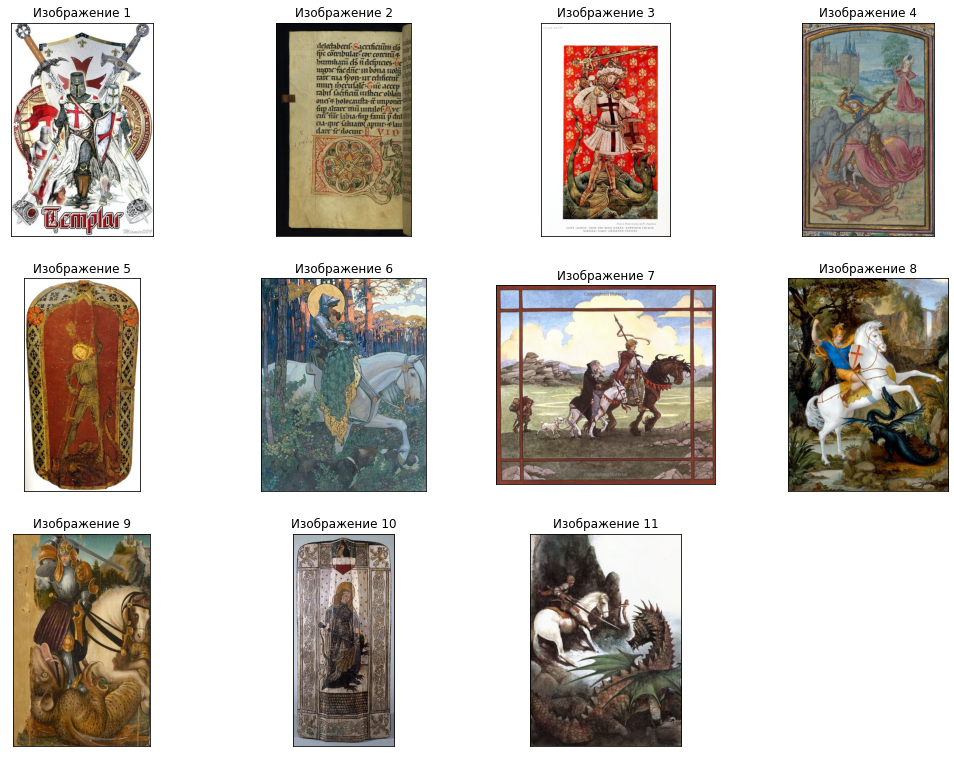

In [4]:
ambiguous = pd.Series(list(set(georges.image_id) & set(non_georges.image_id)))

fig = plt.figure(figsize=(18, 18))

for i in range(len(ambiguous)):
    image = Image.open(path + '/' + ambiguous.iloc[i])
    image = np.array(image)
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title(f"Изображение {i+1}")

Судя по всему, изображения с двумя метками могут относиться и к метке '1', и к метке '0'. Так как таких изображений всего 11, удалим их из выборки.

In [5]:
data = pd.concat([georges, non_georges]).drop_duplicates(subset='image_id', keep=False).reset_index(drop=True)
display(data.head(3))
print('Размер датафрейма: {}'.format(data.shape))

,image_id,label
0,170d5b93d80d247be60f22ca1216bef7.jpg,1
1,47b99a2ddcde2cf9e62b4faeec2fdf20.jpg,1
2,90e890f054b920308987c140125c9d19.jpg,1


Размер датафрейма: (5678, 2)


## 3. Подготовка к обучению модели.

Разобьем изображения на обучающую и тестовую выборки в соотношении 9 к 1.

In [6]:
train, test = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=SEED)

Для передачи изображений на обучение батчами создадим два объекта `ImageDataGenerator`. В обучающий генератор также добавим аугментации с использованием библиотеки `albumentations`: случайное изменение яркости и контраста, отражение по вертикали и смещения/повороты изображения.

In [7]:
def transform(image):
    aug = A.Compose([
        A.RandomBrightnessContrast(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(rotate_limit=20),
    ])
    return aug(image=image)['image']

train_datagen = ImageDataGenerator(validation_split=0.2, 
                                   preprocessing_function=transform)

train_datagen_flow = train_datagen.flow_from_dataframe(
dataframe=train,
validate_filenames=False,
directory=path,
x_col='image_id',
y_col='label',
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='binary',
subset='training',
seed=SEED)

val_datagen = ImageDataGenerator(validation_split=0.2)

val_datagen_flow = val_datagen.flow_from_dataframe(
dataframe=train,
validate_filenames=False,
directory=path,
x_col='image_id',
y_col='label',
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='binary',
subset='validation',
seed=SEED)

Found 4088 non-validated image filenames belonging to 2 classes.
Found 1022 non-validated image filenames belonging to 2 classes.


В качестве модели используем архитектуру `EfficientNetB3`, предобученную на наборе изображений `'imagenet'`. Выходной слой будет состоять из одного нейрона и сигмоидной активацией.

In [8]:
backbone = EfficientNetB3(include_top=False, 
                          weights='imagenet',
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 10,785,072
Trainable params: 10,697,769
Non-trainable params: 87,303
_________________________________________________________________


Компилируем модель. В качестве оптимизатора выбираем `Adam`, метрика - `accuracy`.

Также создадим callbacks: первый будет сохранять модель при достижении лучшей метрики на каждой эпохе, второй будет уменьшать скорость обучения при выходе функции потерь на "плато".

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
checkpoint = ModelCheckpoint(filepath='./best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau( 
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    mode='min',
    verbose=1
)

callbacks = [checkpoint, reduce_lr]

In [11]:
train_steps = np.ceil(train_datagen_flow.n/train_datagen_flow.batch_size)
val_steps = np.ceil(val_datagen_flow.n/val_datagen_flow.batch_size)

## 4. Обучение модели.

Обучим модель на 20 эпохах.

In [12]:
history = model.fit(
    train_datagen_flow,
    epochs = 20,
    steps_per_epoch = train_steps,
    validation_data = val_datagen_flow,
    validation_steps = val_steps,
    callbacks = callbacks)

Epoch 1/20
128/128 [==============================] - 214s 1s/step - loss: 0.6721 - accuracy: 0.6276 - val_loss: 0.8570 - val_accuracy: 0.7730

Epoch 00001: val_loss improved from inf to 0.85698, saving model to ./best_model.h5
Epoch 2/20
128/128 [==============================] - 185s 1s/step - loss: 0.5717 - accuracy: 0.6796 - val_loss: 0.8685 - val_accuracy: 0.7485

Epoch 00002: val_loss did not improve from 0.85698
Epoch 3/20
128/128 [==============================] - 185s 1s/step - loss: 0.5256 - accuracy: 0.7062 - val_loss: 0.4460 - val_accuracy: 0.8082

Epoch 00003: val_loss improved from 0.85698 to 0.44602, saving model to ./best_model.h5
Epoch 4/20
128/128 [==============================] - 185s 1s/step - loss: 0.5004 - accuracy: 0.7229 - val_loss: 1.4892 - val_accuracy: 0.7094

Epoch 00004: val_loss did not improve from 0.44602
Epoch 5/20
128/128 [==============================] - 185s 1s/step - loss: 0.5393 - accuracy: 0.7093 - val_loss: 0.3402 - val_accuracy: 0.8708

Epoch 

Сделаем визуализацию полученных значений точности и потерь модели по эпохам.

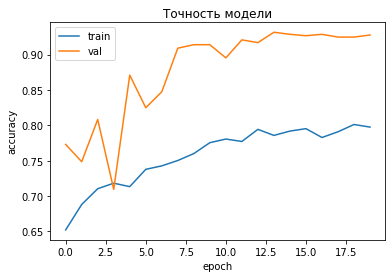

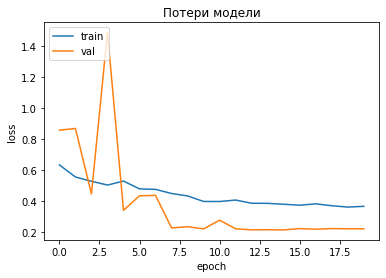

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери модели')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 5. Проверка модели.

Проверим модель на тестовой выборке. Будем использовать модель с минимальной функцией потерь, сохраненую во время обучения.


In [14]:
best_model = load_model('./best_model.h5')

y_pred = []

for image_name in test['image_id']:
    img = image_prep.load_img(path + '/' + image_name, target_size=(IMG_SIZE, IMG_SIZE))
    x = image_prep.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prediction = best_model.predict(x)
    prediction = (prediction > 0.5).astype(int)
    y_pred.extend(prediction)

y_true = test['label'].astype(int)
y_pred = np.concatenate(y_pred)

print('Точность на тестовой выборке: {:.4f}'.format(accuracy_score(y_true, y_pred)))

Точность на тестовой выборке: 0.9261


## 6. Выводы.

Мы построили модель классификации наличия святого Георгия на изображении. Для этого мы использовали архитектуру `EfficientNetB3`, для обучения также использовали аугментации от `albumentations`. 

1. Точность модели на обучающей выборке составила **0.7905**, а на валидационной выборке **0.9286**.
2. Точность модели на тестовой выборке составила **0.9261**.
3. Для дальнейшего улучшения качества модели можно попробовать проделать следующее:

    3.1. Увеличить размер обрабатываемых изображений (также увеличит время обучения).

    3.2. Использовать другую архитектуру сети, либо добавить скрытые слои в существующую модель.

    3.3. Добавить (или использовать другие) аугментации.
